In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [3]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient temperature
temperature = new_data[['AMBIENT_TEMPERATURE']]
print(temperature)

# count the NaN values
nan_count_temperature = temperature['AMBIENT_TEMPERATURE'].isna().sum()
print(nan_count_temperature)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=temperature.index.min(), end=temperature.index.max(), freq='5T')
missing_timestamps = complete_range.difference(temperature.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
temperature_incomplete = df_complete_range.merge(temperature, left_index=True, right_index=True, how='left')
# print(temperature_incomplete)
temperature_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
temperature_all = temperature_incomplete.bfill()
print(temperature_all)
temperature_all.isna().sum() # okay

str(temperature_all.index.dtype) # okay

parameter_type             AMBIENT_TEMPERATURE
acquisition_timestamp                         
2020-10-13 10:20:00+00:00                  7.4
2020-10-13 10:25:00+00:00                  7.5
2020-10-13 10:30:00+00:00                  7.4
2020-10-13 10:35:00+00:00                  7.5
2020-10-13 10:40:00+00:00                  7.6
...                                        ...
2023-05-31 21:35:00+00:00                 14.0
2023-05-31 21:40:00+00:00                 13.9
2023-05-31 21:45:00+00:00                 13.9
2023-05-31 21:50:00+00:00                 13.9
2023-05-31 21:55:00+00:00                 13.9

[271508 rows x 1 columns]
0
5112
                           AMBIENT_TEMPERATURE
2020-10-13 10:20:00+00:00                  7.4
2020-10-13 10:25:00+00:00                  7.5
2020-10-13 10:30:00+00:00                  7.4
2020-10-13 10:35:00+00:00                  7.5
2020-10-13 10:40:00+00:00                  7.6
...                                        ...
2023-05-31 21:35:00+00:00 

'datetime64[ns, UTC]'

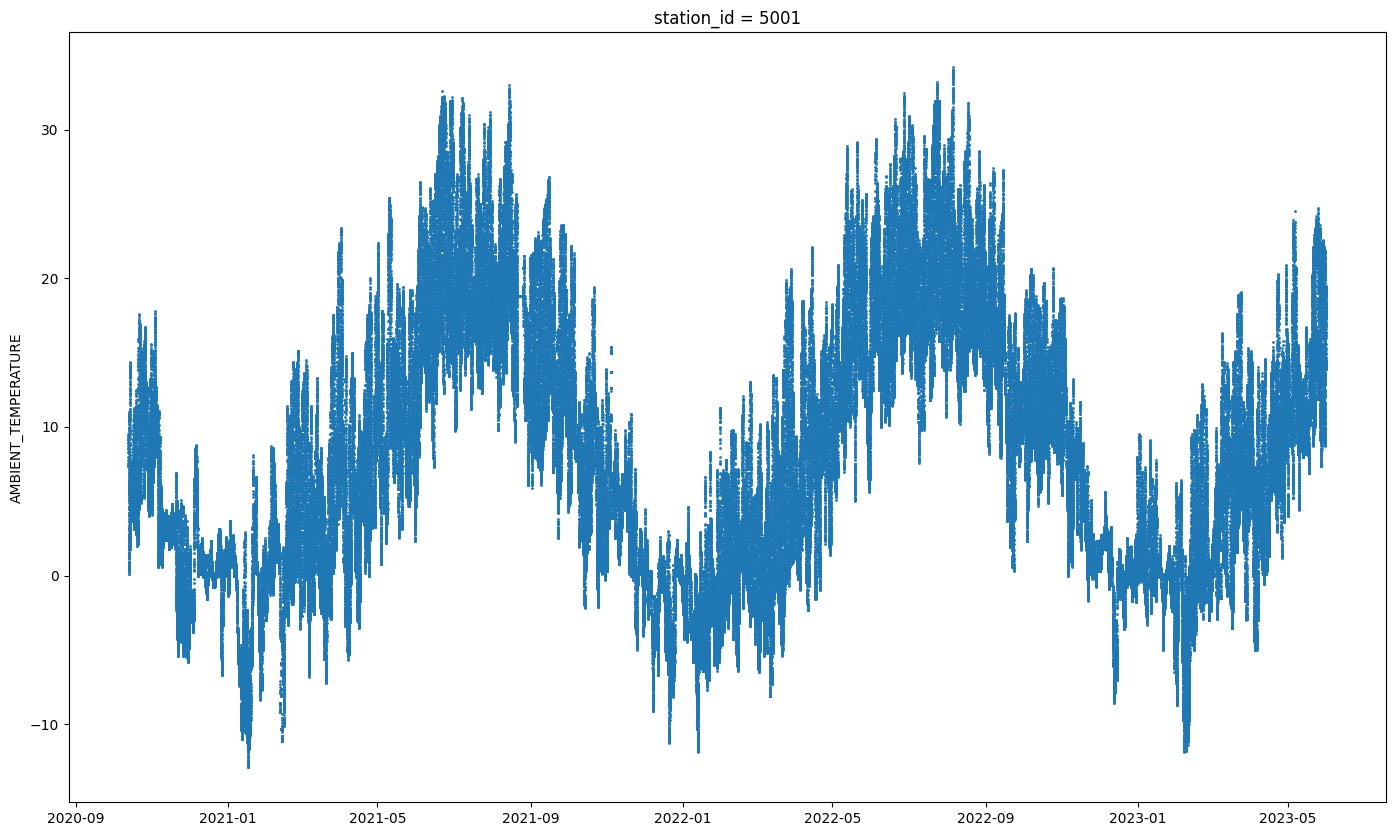

In [4]:
# plot 'AMMBIENT_TEMPERATURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(temperature_all.index, temperature_all['AMBIENT_TEMPERATURE'],s=1)
ax.set_ylabel('AMBIENT_TEMPERATURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           AMBIENT_TEMPERATURE
2020-10-13 10:00:00+00:00             7.687500
2020-10-13 11:00:00+00:00             8.958333
2020-10-13 12:00:00+00:00            10.183333
2020-10-13 13:00:00+00:00            10.716667
2020-10-13 14:00:00+00:00            10.833333
...                                        ...
2023-05-31 17:00:00+00:00            18.708333
2023-05-31 18:00:00+00:00            17.141667
2023-05-31 19:00:00+00:00            15.525000
2023-05-31 20:00:00+00:00            14.341667
2023-05-31 21:00:00+00:00            13.983333

[23052 rows x 1 columns]


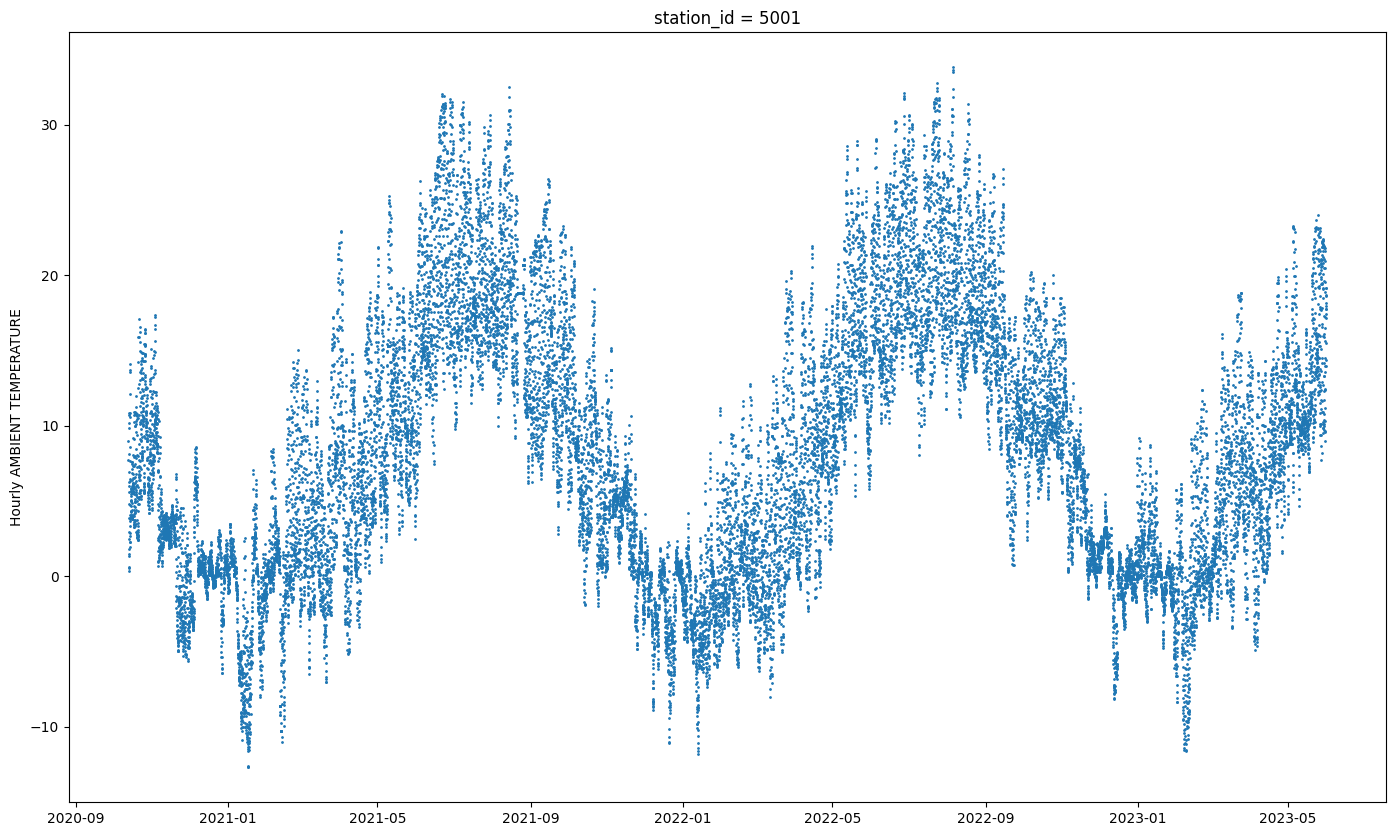

In [5]:
# hourly data
# sum the values for each hour and take the mean

str(temperature_all.index.dtype) # okay
temperature_hourly = temperature_all.resample('H').mean()
print(temperature_hourly)

# plot hourly 'AMBIENT_TEMPERATURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(temperature_hourly.index, temperature_hourly['AMBIENT_TEMPERATURE'],s=1)
ax.set_ylabel('Hourly AMBIENT TEMPERATURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

In [6]:
# ARIMA for all the hourly ambient temperature data
from pmdarima import auto_arima
stepwise_fit = auto_arima(temperature_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=50469.450, Time=12.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69218.443, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=50873.932, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55963.502, Time=2.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69216.444, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=50476.504, Time=4.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=50474.208, Time=7.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=28.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=46162.044, Time=36.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=50403.425, Time=7.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=47390.865, Time=44.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=45979.163, Time=41.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=50400.077, Time=33.92 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=46100.180, Time=50.10 sec
 ARIMA(2,1,5)(0,0,

                                SARIMAX Results                                
Dep. Variable:     AMBIENT_TEMPERATURE   No. Observations:                23052
Model:                  ARIMA(2, 1, 5)   Log Likelihood              -22822.802
Date:                 Fri, 17 May 2024   AIC                          45661.603
Time:                         01:51:57   BIC                          45725.967
Sample:                     10-13-2020   HQIC                         45682.517
                          - 05-31-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9151      0.001   1319.656      0.000       1.912       1.918
ar.L2         -0.9814      0.001   -694.979      0.000      -0.984      -0.979
ma.L1         -1.2782      0.004   -345.101 

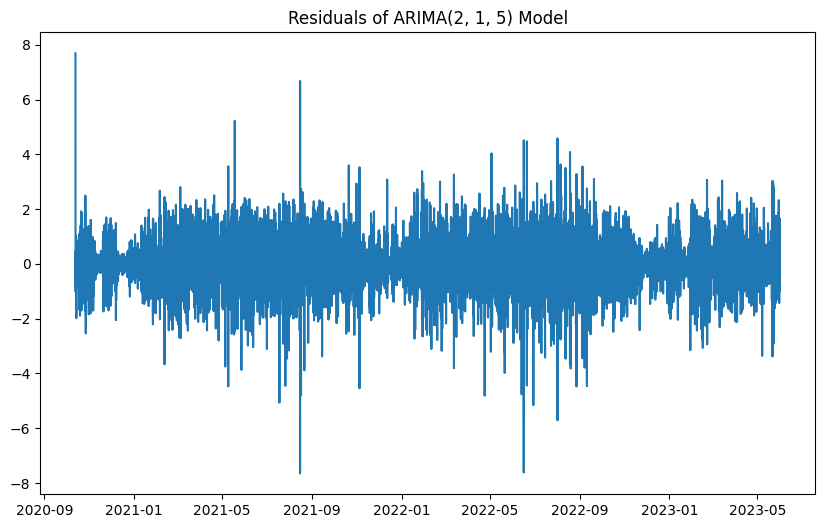

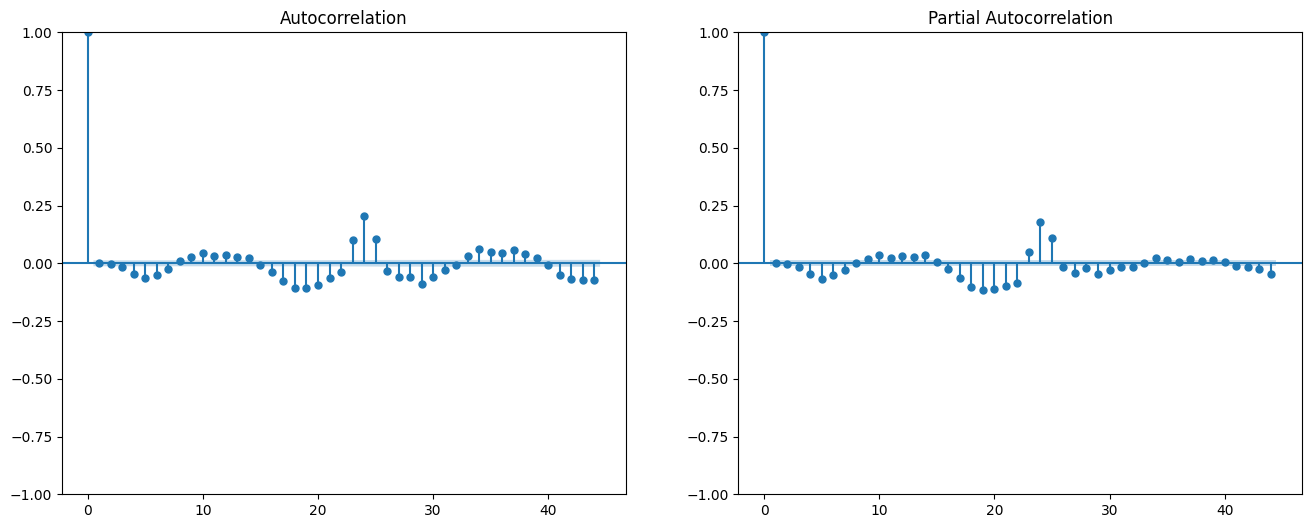

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(temperature_hourly, order=(2,1,5))
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,5} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()